# Maternal Health Risk Assessment

Maternal mortality remains a significant public health challenge globally, particularly in low- and middle-income countries. It refers to deaths due to complications from pregnancy or childbirth, often from preventable causes such as high blood pressure, infections, or untreated health conditions.

Early identification of high-risk pregnancies is critical for improving maternal outcomes. By leveraging machine learning techniques, we can explore the potential of clinical data to support more timely and accurate risk assessments. This notebook investigates the use of classification models to predict maternal risk levels based on health-related features such as blood pressure, BMI, and medical history.



## Table of content

1. **Data understanding**
2. **Basic EDA**
3. **Classification**
4. **Result**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import shap

## 1. Data understanding

### Source link

Source link: [Maternal Health Risk Assessment Dataset](https://data.mendeley.com/datasets/p5w98dvbbk/1)  

Metadata is available in [the published article](https://www.sciencedirect.com/science/article/pii/S2352340925000952)

All rights and credit for the dataset go to its original creators.

### Domain description

This dataset comes from the medical domain, specifcially the speciality of obstetrics. This specialty concerns the health and wellbeing during pregnancy, childbirth, and the postpartum period. Each row is an instance of a patient and contains a list of potential risk factors that have been linked to complications in pregnancy. Together, these risk factors give the patient a risk profile of low or high. The aim is to provide a data on health related factors that can influence maternal and fetal health outcomes. The dataset enables analysis of how these factors are associated to each other, and how presence of a health risk factor can predict a patient's risk profile.

The data were collected from clinical records at a hopspial in Kurigram, Bangladesh, on August 29, 2023.

### Data file structure

**File format**  
The dataset consists of a single tabular .csv file. Thus, only one file needs to be downloaded to access all features.

**Header**  

It has a header that contains the features names, such as systolic BP, BS, Risk level.

**Meta data**  
The dataset does not contain any additional metadata. Howerever, most necessary metadata is available in the article associated with the dataset.

**How are data values separated**  
Values are separated by a comma (e.g. 22,90,60,9,100,18,1,1,0,1,80,High).

### Features and observations

The dataset contains 12 features (seven numerical and five categorical), and 1206 observations.

**Numerical features**

The dataset contains the following numerical features, measured by these units:  
* Age - years
* Systolic BP - mmHg
* Diastolic - mmHg
* BS (Blood sugar) - mmol/L
* Body Temp - &deg;F
* BMI - $\mathrm{kg/m^2}$
* Heart Rate - beats per minute (bpm)  
  
**Categorical features**

Does it contain categorical features? Describe how many, the labels, and whether they are ordinal or nominal.

The dataset contains the following categorical features:

* Previous complications - Nominal (values: 0 = no, 1= yes)
* Preexisting diabetes - Nominal (values: 0 = no, 1= yes)
* Gestational diabetes - Nominal(values: 0 = no, 1= yes)
* Mental Health - Nominal (values: 0 = no, 1= yes)
* Risk Level - Ordinal (Values: Low, High)

**Binary features**

All five categorical features are binary. Four of them are expressed as booleans (0/false = condition not present, 1/true = condition present), and one is an binary ordinal with the values low or high.

## 2. Basic EDA

### Upload dataset

Here the file containing the dataset will be loaded, allowing it to be accessed by the notebook.

In [2]:
df = pd.read_csv("Dataset - Updated.csv")
df.head()

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level
0,22,90.0,60.0,9.0,100,18.0,1.0,1.0,0,1,80.0,High
1,22,110.0,70.0,7.1,98,20.4,0.0,0.0,0,0,74.0,Low
2,27,110.0,70.0,7.5,98,23.0,1.0,0.0,0,0,72.0,Low
3,20,100.0,70.0,7.2,98,21.2,0.0,0.0,0,0,74.0,Low
4,20,90.0,60.0,7.5,98,19.7,0.0,0.0,0,0,74.0,Low


### Datatypes

Here I will check what datatypes it contains, to confirm that they are accurate.

In [3]:
# Starting with checking how many columns contain null values, as this may impact datatypes

In [4]:
df.isnull().sum()

,0
Age,0
Systolic BP,5
Diastolic,4
BS,2
Body Temp,0
BMI,18
Previous Complications,2
Preexisting Diabetes,2
Gestational Diabetes,0
Mental Health,0


In [5]:
df.dtypes

,0
Age,int64
Systolic BP,float64
Diastolic,float64
BS,float64
Body Temp,int64
BMI,float64
Previous Complications,float64
Preexisting Diabetes,float64
Gestational Diabetes,int64
Mental Health,int64


#### Incorrect datatypes
* Systolic and diastolic blood pressure should be integers, as they are listed at whole numbers in the original and blood pressure is normally registered as whole number in clinical practice. However, they contain null values, which means pandas will consider them floats. Because of this they won't be changed to int in the preprocessing, but rather when necessary during analysis.
* Body temp is interpreted as an integer, and all values in the datasets are integers, but in clinical practice it would often be registered with decimals. To ensure consistency with how this measurement is typically documented and to allow for more precise calculations, the column will be converted to float.
* Previous complications, preexisting diabetes, gestational diabetes, and mental health are all categorical values expressed as booleans, and will thus be converted into booleans.
* Heart rate should be integer, as it can only be counted in whole numbers. But as it contains null values it will remain a float until analysis.
* Risk Level is listed as an object. However, as it is an ordinal binary feature, with a small, fixed number of values, category would make a better datatype.

### Preprocessing

In this section the content of the dataset will be cleaned and prepared for future analyses. This will be performed in the following steps:  

* **Renaming of features**  
Some features will be renamed to be more intelligeble, or consistent with the naming of other features in the set.

* **Correction of datatypes**  
Datatypes will be assigned correct values.

* **Management of missing values**  
Potential null values will be located and managed appropriately.

* **Control the plausability of listed values**  
All features will be screened for values that are obvious errors.

* **Feature selection**  
All features present in the dataset are considered useful and necessary for analyses, thus no features will be removed.


In [6]:
# Creating a copy of the dataframe instead of editing the raw file directly

df_clean = df.copy()

#### Renaming of features

This is the first step performed, at it makes sense to rename the features before manipulating them in other ways. The following changes will be made:  

* Diastolic → Diastolic BP
* BS → Blood Sugar

In [7]:
df_clean.rename(columns={'Diastolic': 'Diastolic BP', 'BS': 'Blood Sugar'}, inplace=True)

df_clean.head()

,Age,Systolic BP,Diastolic BP,Blood Sugar,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level
0,22,90.0,60.0,9.0,100,18.0,1.0,1.0,0,1,80.0,High
1,22,110.0,70.0,7.1,98,20.4,0.0,0.0,0,0,74.0,Low
2,27,110.0,70.0,7.5,98,23.0,1.0,0.0,0,0,72.0,Low
3,20,100.0,70.0,7.2,98,21.2,0.0,0.0,0,0,74.0,Low
4,20,90.0,60.0,7.5,98,19.7,0.0,0.0,0,0,74.0,Low


#### Correction of datatypes

Most categorical values are boolean, but currently intepreted as integers. To ensure that potiential missing values are recogognized and handled correctly, all data types will be corrected before missing values are processed.

**Datatypes managed in this section**

* Body Temp → float  
* Previous complications, preexisting diabetes, gestational diabetes, and mental health → booleans
* Risk level → category

In [8]:
# Change Body Temp to float
df_clean["Body Temp"] = df_clean["Body Temp"].astype("Float64")

# Convert relevant columns to boolean
df_clean["Previous Complications"] = df_clean["Previous Complications"].astype("boolean")
df_clean["Preexisting Diabetes"] = df_clean["Preexisting Diabetes"].astype("boolean")
df_clean["Gestational Diabetes"] = df_clean["Gestational Diabetes"].astype("boolean")
df_clean["Mental Health"] = df_clean["Mental Health"].astype("boolean")

# Change Risk Level to an ordered categorical variable (Low < High)
df_clean["Risk Level"] = pd.Categorical(df_clean["Risk Level"], categories=["Low", "High"], ordered=True)

# Check datatypes after conversion
df_clean.dtypes


,0
Age,int64
Systolic BP,float64
Diastolic BP,float64
Blood Sugar,float64
Body Temp,Float64
BMI,float64
Previous Complications,boolean
Preexisting Diabetes,boolean
Gestational Diabetes,boolean
Mental Health,boolean


#### Management of missing values

**Identifying empty rows**

First, potentially empty rows will be identified. If there are any, they will be removed.  

**Identifying missing values**    

Potential missing values in individual columns are handled by suppressing them, but no mean values are assigned as fillers during this EDA assignment. Entire rows are not deleted, as they often contain other valid values that can be used for analysis. Instead, such rows are simply ignored when working with columns that contain null values.

This approach is preferred over assigning average values, as imputation at this stage could skew results. Additionally, many of the features in this dataset are of object or boolean types, which cannot easily be imputed with averages.

While suppression flags serve no direct purpose in this stage of the assignment, they may become useful later during classification, where numerical columns with missing values may require imputation. For now, suppression is in place, and further handling of missing values will be addressed when needed.

In [9]:
#Looking for empty rows

empty_rows = df_clean.isna().all(axis=1)

print(empty_rows.any())

False


This confirms that there are no empty rows. Next step is to look for null values.

In [10]:
# Finding potential null values

df_clean.isnull().sum()[df_clean.isnull().sum() > 0] # Only show rows where the count of null values exceeds 0

,0
Systolic BP,5
Diastolic BP,4
Blood Sugar,2
BMI,18
Previous Complications,2
Preexisting Diabetes,2
Heart Rate,2
Risk Level,18


This shows all the features with missing values. These will be flagged using suppression columns before moving on.

In [11]:
# Create new features that flag missing values
# Change new features to pandas 'boolean' type to ensure missing values are handled correctly
df_clean["Systolic BP Suppressed"] = df_clean["Systolic BP"].isnull().astype("boolean")
df_clean["Diastolic BP Suppressed"] = df_clean["Diastolic BP"].isnull().astype("boolean")
df_clean["Blood Sugar Suppressed"] = df_clean["Blood Sugar"].isnull().astype("boolean")
df_clean["BMI Suppressed"] = df_clean["BMI"].isnull().astype("boolean")
df_clean["Previous Complications Suppressed"] = df_clean["Previous Complications"].isnull().astype("boolean")
df_clean["Preexisting Diabetes Suppressed"] = df_clean["Preexisting Diabetes"].isnull().astype("boolean")
df_clean["Heart Rate Suppressed"] = df_clean["Heart Rate"].isnull().astype("boolean")
df_clean["Risk Level Suppressed"] = df_clean["Risk Level"].isnull().astype("boolean")

df_clean.head()


,Age,Systolic BP,Diastolic BP,Blood Sugar,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level,Systolic BP Suppressed,Diastolic BP Suppressed,Blood Sugar Suppressed,BMI Suppressed,Previous Complications Suppressed,Preexisting Diabetes Suppressed,Heart Rate Suppressed,Risk Level Suppressed
0,22,90.0,60.0,9.0,100.0,18.0,True,True,False,True,80.0,High,False,False,False,False,False,False,False,False
1,22,110.0,70.0,7.1,98.0,20.4,False,False,False,False,74.0,Low,False,False,False,False,False,False,False,False
2,27,110.0,70.0,7.5,98.0,23.0,True,False,False,False,72.0,Low,False,False,False,False,False,False,False,False
3,20,100.0,70.0,7.2,98.0,21.2,False,False,False,False,74.0,Low,False,False,False,False,False,False,False,False
4,20,90.0,60.0,7.5,98.0,19.7,False,False,False,False,74.0,Low,False,False,False,False,False,False,False,False


**Checking data types**

Confirming that all features, including the newly created ones, still have the right data types.

In [12]:
df_clean.dtypes

,0
Age,int64
Systolic BP,float64
Diastolic BP,float64
Blood Sugar,float64
Body Temp,Float64
BMI,float64
Previous Complications,boolean
Preexisting Diabetes,boolean
Gestational Diabetes,boolean
Mental Health,boolean


#### Control the plausability of listed values

As a last step, before analyssing the data further, I will check minimum and maximum values of all numeric features. This is to ensure that all values used for analysis, and later on classification, are within the possible range and do not contain any incorrect output.

In [13]:
# Create list that will contain all max and min values for selected features
summary = []

# Filter to numeric columns only
numeric_cols = df_clean.select_dtypes(include="number").columns

# # Loop through columns to collect min and max values
for col in numeric_cols:
  col_data = df_clean[col]
  max_value = col_data.max()
  min_value = col_data.min()
  summary.append([col, max_value, min_value])

# Create a DataFrame to display the result
show_summary = pd.DataFrame(summary, columns=["Feature", "Max", "Min"]) # Adjust display layot for enhanced readability
show_summary = show_summary[["Feature", "Min", "Max"]] #order the columns from min to max
show_summary

,Feature,Min,Max
0,Age,10.0,325.0
1,Systolic BP,70.0,200.0
2,Diastolic BP,40.0,140.0
3,Blood Sugar,3.0,19.0
4,Body Temp,97.0,103.0
5,BMI,0.0,37.0
6,Heart Rate,58.0,92.0


Two values are identified as clearly incorrect:
- Age = 325 years
- BMI = 0

These values are not physiologically possible and are therefore removed to avoid distortion of model training and interpretation.

Other extreme values are identified but not immediately dismissed:
- Age = 10: Unusual in the context of maternal health, but not impossible.
- Diastolic blood pressure = 140 mmHg: Critically high, but possible in rare medical emergencies.
- Blood sugar = 19 mmol/L: Indicative of severe hyperglycemia, but not impossible.

To assess whether these rows are reliable, I will examine whether they are flagged as **high risk** in the target variable. If the target classifies them as high risk, I interpret them as extreme but plausible cases and retain them. If, however, such values are paired with a **'Low' risk label**, they are likely inconsistent and are removed.


In [14]:
# Remove rows where age = 325 and BMI = 0

df_clean = df_clean[(df_clean["Age"] != 325) & (df_clean["BMI"] != 0)]

In [15]:
df_clean[df_clean["Diastolic BP"] > 120]

,Age,Systolic BP,Diastolic BP,Blood Sugar,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level,Systolic BP Suppressed,Diastolic BP Suppressed,Blood Sugar Suppressed,BMI Suppressed,Previous Complications Suppressed,Preexisting Diabetes Suppressed,Heart Rate Suppressed,Risk Level Suppressed
141,22,180.0,140.0,7.7,98.0,17.8,True,False,True,True,87.0,High,False,False,False,False,False,False,False,False
154,23,180.0,130.0,7.8,98.0,29.0,True,False,True,True,88.0,High,False,False,False,False,False,False,False,False


Two cases of extremely high diastolic pressure was identified, both labled **high risk**

In [16]:
df_clean[df_clean["Age"] > 50]

,Age,Systolic BP,Diastolic BP,Blood Sugar,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level,Systolic BP Suppressed,Diastolic BP Suppressed,Blood Sugar Suppressed,BMI Suppressed,Previous Complications Suppressed,Preexisting Diabetes Suppressed,Heart Rate Suppressed,Risk Level Suppressed
509,63,140.0,90.0,15.0,98.0,26.9,False,True,False,True,90.0,High,False,False,False,False,False,False,False,False
512,55,140.0,100.0,18.0,98.0,26.0,False,True,False,False,90.0,High,False,False,False,False,False,False,False,False
518,55,129.0,85.0,7.5,98.0,25.0,False,False,False,False,88.0,Low,False,False,False,False,False,False,False,False
546,60,90.0,65.0,6.8,98.0,29.0,False,False,False,False,77.0,Low,False,False,False,False,False,False,False,False
553,60,90.0,65.0,6.8,98.0,19.0,False,True,False,False,77.0,Low,False,False,False,False,False,False,False,False
554,55,120.0,90.0,6.8,98.0,18.6,False,False,False,False,78.0,Low,False,False,False,False,False,False,False,False
557,60,140.0,90.0,12.0,98.0,34.0,False,True,True,False,87.0,High,False,False,False,False,False,False,False,False
558,55,100.0,70.0,6.8,98.0,24.5,False,False,False,False,76.0,Low,False,False,False,False,False,False,False,False
559,60,140.0,80.0,16.0,98.0,26.0,False,True,False,True,60.0,High,False,False,False,False,False,False,False,False
562,60,120.0,80.0,6.8,98.0,24.9,False,False,False,True,77.0,Low,False,False,False,False,False,False,False,False


Several individuals aged over 50 are labeled as "Low" risk. Clinically, pregnancies in women above 50 are extremely rare, usually only possible through IVF (which in itself would make a pregnancy higher risk) and typically considered high risk due to increased likelihood of complications.

In [17]:
df_clean[df_clean["Age"] < 15]

,Age,Systolic BP,Diastolic BP,Blood Sugar,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level,Systolic BP Suppressed,Diastolic BP Suppressed,Blood Sugar Suppressed,BMI Suppressed,Previous Complications Suppressed,Preexisting Diabetes Suppressed,Heart Rate Suppressed,Risk Level Suppressed
543,12,120.0,95.0,7.8,98.0,25.0,False,False,False,False,68.0,Low,False,False,False,False,False,False,False,False
618,13,90.0,65.0,7.9,98.0,22.0,False,False,False,False,80.0,Low,False,False,False,False,False,False,False,False
639,13,90.0,65.0,7.9,101.0,22.0,False,False,False,False,80.0,Low,False,False,False,False,False,False,False,False
664,12,95.0,60.0,6.9,98.0,22.0,False,False,False,False,65.0,Low,False,False,False,False,False,False,False,False
674,13,90.0,65.0,6.8,101.0,19.4,False,False,False,True,80.0,Low,False,False,False,False,False,False,False,False
684,12,120.0,95.0,6.8,98.0,23.0,False,False,False,False,60.0,Low,False,False,False,False,False,False,False,False
691,12,120.0,90.0,6.8,98.0,24.4,False,False,False,False,80.0,Low,False,False,False,False,False,False,False,False
728,12,90.0,60.0,6.5,102.0,22.0,False,False,False,False,66.0,Low,False,False,False,False,False,False,False,False
750,10,100.0,50.0,6.0,99.0,18.9,False,False,False,False,70.0,Low,False,False,False,False,False,False,False,False
751,12,100.0,50.0,6.4,98.0,19.0,False,False,False,False,70.0,Low,False,False,False,False,False,False,False,False


Several patients under the age of 15 are present in the dataset, and all are labeled as low risk. In clinical practice, however, patients that young would often be considered high risk simply due to their age.

A notable number of patients over the age of 50 are also labeled as low risk. While these cases might reflect individuals who experienced uncomplicated pregnancies, they represent a small portion of the overall dataset. Therefore, they may not be representative of the broader population of extremely young or older pregnant patients. This underrepresentation at both extremes of the age spectrum could introduce bias into the model. Specifically, it may reduce the model’s ability to accurately predict risk for very young or older patients. These cases should be considered a potential source of label noise and a limitation of the current dataset.

Before deciding how to move on, I will further investigte how age impact on total risk factors.


#### How does the average number of maternal risk factors vary across different ages?

This is a multivariate question examining the avarage number or risk factors assiciated with each age. A limitation of both the dataset and metadata is the absence of clinical definitions for when numeric values are considered risky.  For the purposes of this analysis, reference points for maternal health vitals and lab results have been taken from the American College of Obstetricians and Gynecologists (ACOG).   

For categorical features, the presence of a condition is considered a risk factor.  For numeric features, the following thresholds have been used to define risk:

* Systolic BP &ge; 140 mmHg  
* Diastolic BP &ge; 90 mmHg  
* Blood sugar &ge; 5.6 mmol/L  
* Body temperature &ge; 100.4&deg;F  
* BMI &ge; 25  
* Heart rate &ge; 100 bpm  

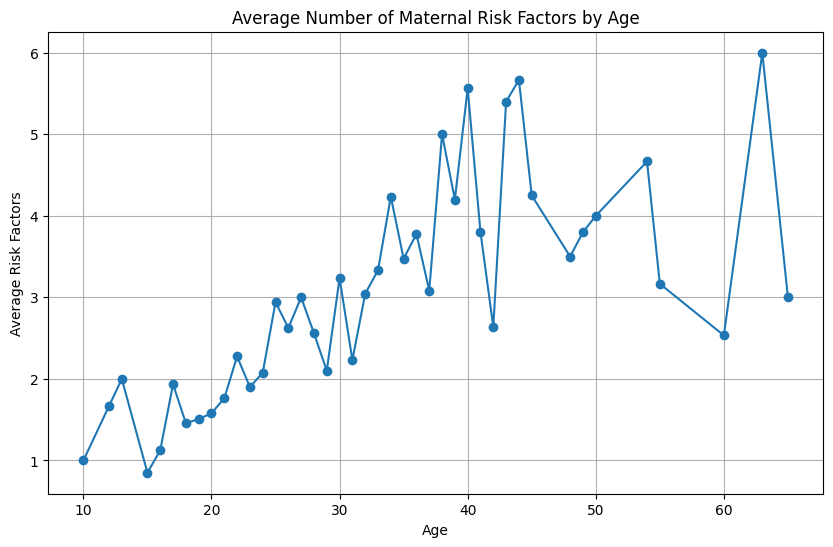

In [18]:
# creates new binary features indicating presence of risk factor
df_clean["Syst_BP_Risk"] = df_clean["Systolic BP"] >= 140
df_clean["Diast_BP_Risk"] = df_clean["Diastolic BP"] >= 90
df_clean["BS_Risk"] = df_clean["Blood Sugar"] >= 5.6
df_clean["Temp_Risk"] = df_clean["Body Temp"] >= 100.4
df_clean["BMI_Risk"] = df_clean["BMI"] >= 25
df_clean["HR_Risk"] = df_clean["Heart Rate"] >= 100
df_clean["Prev_Cond_Risk"] = df_clean["Previous Complications"] == True
df_clean["Pre_Diabetes_Risk"] = df_clean["Preexisting Diabetes"] == True
df_clean["Gest_Diabetes_Risk"] = df_clean["Gestational Diabetes"] == True
df_clean["MH_Risk"] = df_clean["Mental Health"] == True

# filter to exclude missing data
df_risk = df_clean.dropna(subset=["Systolic BP", "Diastolic BP", "Blood Sugar", "Body Temp", "BMI", "Heart Rate", "Previous Complications", "Preexisting Diabetes"]).copy()

# creates a list of risk factor features
risk_columns = ["Syst_BP_Risk", "Diast_BP_Risk", "BS_Risk", "Temp_Risk", "BMI_Risk", "HR_Risk", "Prev_Cond_Risk", "Pre_Diabetes_Risk", "Gest_Diabetes_Risk", "MH_Risk"]

df_risk[risk_columns] = df_risk[risk_columns].astype(int)  # converts boolean values into integers to enable summation

df_risk["Total Risk Factors"] = df_risk[risk_columns].sum(axis=1)  # calculate the total number of risk factors per patient

risk_by_age = df_risk.groupby("Age")["Total Risk Factors"].mean().reset_index()  # group number of risk factors by age and calculate average per age

# create line plot to show result
plt.figure(figsize=(10, 6))
plt.plot(risk_by_age["Age"], risk_by_age["Total Risk Factors"], marker='o', linestyle='-')
plt.title("Average Number of Maternal Risk Factors by Age")
plt.xlabel("Age")
plt.ylabel("Average Risk Factors")
plt.grid(True)
plt.show()


The graph shows the average number of risk factors per age. While it displays an overall upward trend, there is notable variation across individual ages. This suggests that, on a population level, the number of pregnancy-related risk factors tends to increase with age. However, the trend may not reliably reflect individual-level risk, especially in age groups with fewer data points.

For age to serve as a meaningful input feature in a prediction model, the dataset needs to include a sufficiently large and representative sample across all age ranges. Otherwise, predictions for underrepresented age groups—such as very young or older patients—may be biased or inaccurate. It is also possible that different clinics will handle these cases differently, as they are rare even in clincal praxis, and general guidelines may not exist.

Given this, it is reasonable to retain age as a predictive feature but restrict the dataset to a more statistically stable age range. For simplicity and robustness, I will include only patients aged 18 to 45. This filtering will be performed after the EDA is finished, before building the model, as excluding them now may exclude information that may be otherwise helpful in understanding the dataset as is.

In [19]:
# List of original features to make output easier to read after creating new features for age visualization
original_features = ["Age", "Systolic BP", "Diastolic BP", "Blood Sugar", "Body Temp", "BMI",
                     "Previous Complications", "Preexisting Diabetes",
                     "Gestational Diabetes", "Mental Health", "Risk Level"]
df_clean[df_clean["Blood Sugar"] > 15][original_features]

,Age,Systolic BP,Diastolic BP,Blood Sugar,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Risk Level
53,35,160.0,100.0,18.0,98.0,33.0,True,True,True,False,High
57,38,140.0,100.0,17.0,98.0,25.7,True,True,False,False,High
58,48,140.0,96.0,19.0,98.0,27.0,False,True,False,False,High
88,31,140.0,90.0,17.0,98.0,26.6,False,True,False,True,High
94,39,140.0,90.0,18.0,98.0,27.0,True,True,False,False,High
98,41,120.0,85.0,18.0,98.0,27.0,True,True,False,True,High
112,36,130.0,90.0,17.0,98.0,25.3,True,True,False,False,High
121,39,140.0,100.0,18.0,98.0,28.0,True,True,False,True,High
125,39,130.0,100.0,19.0,98.0,27.0,True,True,False,False,High
128,38,140.0,90.0,16.0,101.0,28.0,False,True,False,False,High


In [20]:
df_clean[df_clean["BMI"] < 16][original_features]


,Age,Systolic BP,Diastolic BP,Blood Sugar,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Risk Level
1011,16,125.0,85.0,5.0,98.0,15.0,False,False,True,True,High
1020,17,100.0,60.0,4.7,98.0,15.6,False,False,True,True,High
1038,20,100.0,90.0,7.5,98.0,15.5,True,True,False,True,High
1062,17,110.0,75.0,4.0,101.0,15.9,False,True,False,True,High


There are several patients with alarmingly high blood sugar, all of which seem to be accurate values as they are also labeled high risk.

The dataset also contains a few indivduals considered underweight, who are labeled high risk.

In medical datasets, it is expected to encounter values at both extremes of the clinical range. Including such cases is important to ensure that the model learns to recognize and handle these high-risk scenarios appropriately.

It is worth pointing out that this differs from what I observed with patient age. While extremely young and old patients are often considered high risk in clinical practice, many of these individuals in the dataset are labeled low risk. This inconsistency suggests potential label noise or underrepresentation of complications in these age groups. As such, extreme age values may confuse the model and reduce predictive accuracy unless adequately addressed or filtered.

In [21]:
# New copy of df_clean is made to use during EDA
df_eda = df_clean.copy()

df_eda.head()

,Age,Systolic BP,Diastolic BP,Blood Sugar,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,...,Syst_BP_Risk,Diast_BP_Risk,BS_Risk,Temp_Risk,BMI_Risk,HR_Risk,Prev_Cond_Risk,Pre_Diabetes_Risk,Gest_Diabetes_Risk,MH_Risk
0,22,90.0,60.0,9.0,100.0,18.0,True,True,False,True,...,False,False,True,False,False,False,True,True,False,True
1,22,110.0,70.0,7.1,98.0,20.4,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,27,110.0,70.0,7.5,98.0,23.0,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
3,20,100.0,70.0,7.2,98.0,21.2,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,20,90.0,60.0,7.5,98.0,19.7,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


### Univariate analysis

In this section, two univariate analyses are examined numerically through conditional filtering.

The proposed analyses are:  

* What is the avarage age of patients with previous pregnancy complications?  
* What is the maximun heart rate for high risk patients?

#### What is the avarage age of patients with previous pregnancy complications?

This is a univariate analysis that examines the variable Age, while filtering for previous pregnany complications.  

In [22]:
df_prev_comp = df_eda[df_eda["Previous Complications"] == True] #filtering for rows where previous complications is true

df_prev_comp["Age"].mean() #calculatin mean age for those with previous compliation

print(f"The average age of patients with previous pregnancy complications is {round(df_prev_comp['Age'].mean(), 1)}") #rounding to 1 for readability and to match rounding style in the dataset



The average age of patients with previous pregnancy complications is 31.6


#### Reflection

This shows that the avarage age of patients with previous pregnancy complications is 31.6. As this group only contains patients with previous pregnancies it may seem intuitive that they are older on avarage than those that do not have previous complications, but this is not necessarily true for a multitude of reasons. A univariate analysis is not sufficient to investigate this, as it would need a bivariate comparison. The only certain conclusion from this analysis is the mean age of those with previous complication, not how it compares to other variables.

#### What is the maximun heart rate for high risk patients?

This is a univariate analysis that identifies the maximum value of the heart rate variable, filtered to include only high-risk patients. The output represents the highest recorded heart rate within this subgroup.

In [23]:
df_high_risk = df_eda[df_eda["Risk Level"] == "High"] #filtering for rows where risk level is high
int(df_high_risk["Heart Rate"].max()) #finding max heart rate for high risk patients, converting the output to an integer

92

#### Reflection

The output shows that the highest recorded heart rate among high-risk patients in this dataset is 92 beats per minute. This value falls within the higher end of the normal resting heart rate range. During pregnancy, it is common for heart rate to increase, so a reading in this range is not unexpected.

On its own, a heart rate of 92 bpm would likely not be a cause for concern in either risk group. However, when considered in combination with other clinical indicators it could contribute to a more meaningful assessment of patient status.

### Bivariate analysis

This section provides two bivariate analyses by analyzing two of the variables in the dataset. These analyses will be answered through pivot tables. The analytical questions are:  

* What percentage of patients with preexisting diabetes had low (<3.5 mmol/L), normal (3.5–5.6 mmol/L), or high (>5.6 mmol/L) blood sugar levels?  
* What is the risk level of the 100 patients with the highest pulse pressure?

#### What percentage of patients with preexisting diabetes had low (<3.5 mmol/L), normal (3.5–5.6 mmol/L), or high (>5.6 mmol/L) blood sugar levels?

This is a bivariate question that compares the variable blood sugar (grouped into three different labels) with the variable preexisting diabetes.

There is no mention in the metadata whether the listed values are fasting, but for this analysis it will be assumed that it is fasting. It is worth noting that this can impact the accuracy of the data if that assumption is not correct. The definition of low, normal, and high blood sugar may also vary slightly between different clinical settings. The ranges used here are an approximation and may need adjustment to reflect clinical practice in a specific context.

In [24]:
df_preexisting_diabetes = df_eda[df_eda["Preexisting Diabetes"] == True].copy() #filter data for cases with preexisting diabetes

#assign into groups of low, normal, and high
def blood_sugar_organize(bs):
    if pd.isna(bs):
        return "Missing"
    elif bs < 3.5:
        return "Low"
    elif bs <= 5.6:
        return "Normal"
    else:
        return "High"

df_preexisting_diabetes["Blood Sugar Level"] = df_preexisting_diabetes["Blood Sugar"].apply(blood_sugar_organize) #apply the blood sugar grouping onto the filtered preexisting diabetes data

grouped = df_preexisting_diabetes[df_preexisting_diabetes["Blood Sugar Level"] != "Missing"].groupby("Blood Sugar Level")["Blood Sugar"].count() #ignore missing values

percentages = (grouped / grouped.sum()) * 100 #calculate the percentages of patients in each group
percentages = percentages.sort_values(ascending=False) #ensure result is presented in descending order

print(percentages.round(1))

Blood Sugar Level
High      90.1
Normal     9.6
Low        0.3
Name: Blood Sugar, dtype: float64


#### Reflection

The vast majority (90.1%) of patients with preexisting diabetes had high blood sugar. If these values do not represent fasting measurements, the actual share of patients with high blood sugar may be lower than shown here. Another 9.6% had normal blood sugar, and only 0.3% had low blood sugar.  Whether or not the thresholds used here align with clinical praxis at all clinics, and whether the values reflect fasting or not, the result does suggest that most patients with preexisting diabetes are more affected by high blood sugar than low blood sugar during pregnancy.

#### What is the risk level of the 100 patients with the highest pulse pressure?

Pulse pressure is defined as the difference between systolic and diastolic bloodpressure. A pulse pressure over 40 mmHg has been linked to an increased risk of cardiac disease (see for example [The Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/high-blood-pressure/expert-answers/pulse-pressure/faq-20058189)). This analysis aim to examine if there may also be a link between pulse pressure and risk level in pregnancy.

This is a bivariate analysis that takes the difference between systolic and diastolic blood pressure and creates a new variable called Blood pressure range. The 100 patients with the highest range are then analyzed by risk level to explore whether they are more likely to be classified as high risk or low risk.

In [25]:
df_eda["BP Range"] = df_eda["Systolic BP"] - df_eda["Diastolic BP"] #creates a new features by subtracting diastolic BP from systolic

bp_clean = df_eda[df_eda["Risk Level Suppressed"] == False].copy() #make sure that suppressed/null values are ignored

df_top_100 = bp_clean.sort_values(by="BP Range", ascending=False).head(100) #gets the 100 highest bp ranges

min_bp = int(df_top_100["BP Range"].min()) #Patient with lowest value in the top 100 list
max_bp = int(df_top_100["BP Range"].max()) #Patient with lowest value in the top 100 list

print(f"The pulse pressure ranges from {min_bp} mmHg to {max_bp} mmHg.")

print("\n")

pivot_bp_range = df_top_100.pivot_table(index="Risk Level", values="BP Range", aggfunc="count") #creates pivot table containg bp ranges per risk level category
pivot_bp_range = pivot_bp_range.sort_index(ascending=False) #sorts the pivot table from high to low
print(pivot_bp_range)

The pulse pressure ranges from 60 mmHg to 100 mmHg.


            BP Range
Risk Level          
High              46
Low               54


<ipython-input-25-1465552177>:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_bp_range = df_top_100.pivot_table(index="Risk Level", values="BP Range", aggfunc="count") #creates pivot table containg bp ranges per risk level category


#### Reflection

The result shows that of the 100 patients with the highest pulse pressure, all of them have a value that exceeds 40 mmHg. Out of these, 46 are considered high risk patients, and 54 are low risk. This is a fairly small sample size compared to what is in the whole data set, and even with a bigger sample it would not be possible to determine if there is a statistacally significant difference without further analyses. This analysis also does not consider if the patients have high or low blood pressure, which may likely have a larger impact on risk level than systolic-diastolic range. It is not possible to confirm or refute that BP range may be correlated to risk level from this simple analysis.

### Data visualization

This section contains analyses that will be answered through data visualiation. The four questions are:  

* What is the distrubution of body temperature?
* What are the distributions of systolic and diastolic blood pressure  among low-risk and high-risk patients?  
* What additional maternal risk factors are most common among patients with previous pregnancy related complications?  
* How is BMI related to blood sugar levels and the presence of preexisting or gestational diabetes?

#### * What is the distrubution of body temperature?

This is a univariate question that will be answered through a histogram.

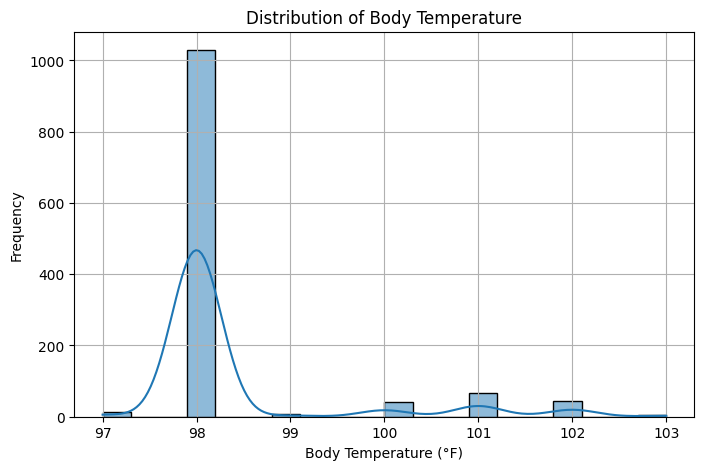

In [26]:
plt.figure(figsize=(8, 5))
sns.histplot(df_clean["Body Temp"], kde=True, bins=20)
plt.title("Distribution of Body Temperature")
plt.xlabel("Body Temperature (°F)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


#### Reflection

The graph suggests that body temperature is relatively consistent across patients, with most values in the normal range. This limited variation, combined with the fact that temperature is only registered one per patient, may reduce its usefulness as a predictive feature. Patients with acute illness or fever may be less likely to attend routine check-ups, meaning fever cases could be underrepresented in the dataset.

For temperature to provide meaningful clinical insight, it would likely need to be contextualized, for example, as a binary indicator of fever of unknown origin or fever related to a pregnancy-relevant infection. Alternatively, a longitudinal measure such as average temperature across multiple visits could be more informative. As the current data lacks that context, body temperature may contribute little to risk prediction in its current form.

#### What are the distributions of systolic and diastolic blood pressure  among low-risk and high-risk patients?  

This is a multivariate analysis examining the distribution of systolic and diastolic blood pressure, filtered by risk level.

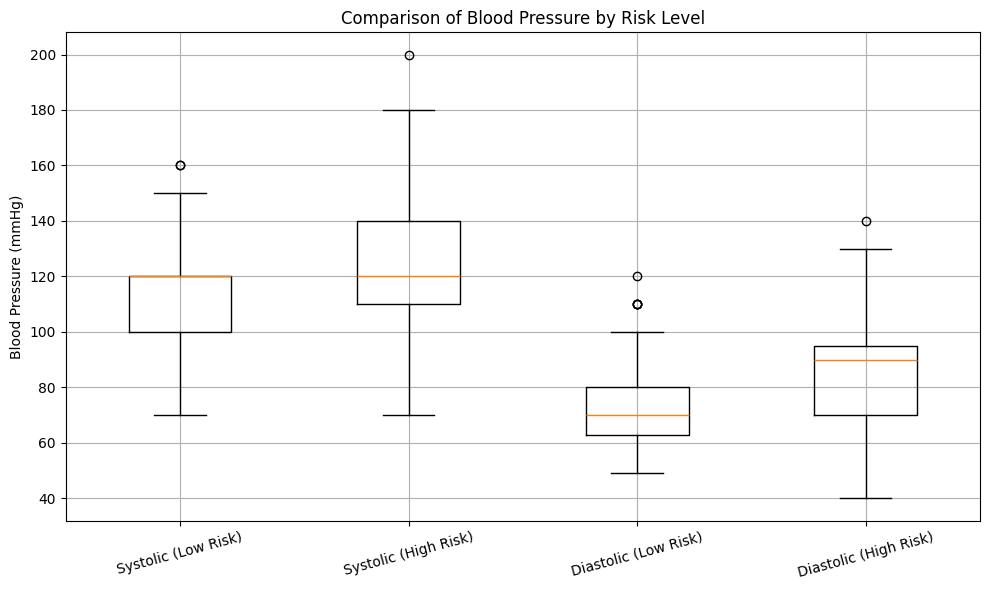

In [27]:
#create two new df that filter for high or low risk
df_high_risk = df_eda[df_eda["Risk Level"] == "High"]
df_low_risk = df_eda[df_eda["Risk Level"] == "Low"]

#create list of bp values, ignoring nulls
data = [df_low_risk["Systolic BP"].dropna(), df_high_risk["Systolic BP"].dropna(), df_low_risk["Diastolic BP"].dropna(), df_high_risk["Diastolic BP"].dropna()]

labels = ["Systolic (Low Risk)", "Systolic (High Risk)", "Diastolic (Low Risk)", "Diastolic (High Risk)"] #create new lables baased on bp and risk level

#create boxplots
plt.figure(figsize=(10, 6))
plt.boxplot(data, tick_labels=labels)
plt.title("Comparison of Blood Pressure by Risk Level")
plt.ylabel("Blood Pressure (mmHg)")
plt.grid(True)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


#### Reflection

The median line for systolic blood pressure is around 120 mm/Hg for both low and high risk patients. For low risk, the median is closer to the upper quartile, indicating that higher bloodpressures are registered in the high risk group. A similar pattern is present in diastolic blood pressure, but here the median is also higher in the high risk group. Both systolic and diastolic readings show a wide spread among high-risk patients, suggesting that blood pressure alone is not the sole factor contributing to a high-risk categorization. However, higher blood pressure seems to be an indicator of a High risk label.

### What additional maternal risk factors are most common among patients with previous pregnancy related complications?

This is a multivariate question looking into all the afformentioned risk factors. In this analysis we will also include age over 35 as a risk (following ACOG guidelines).

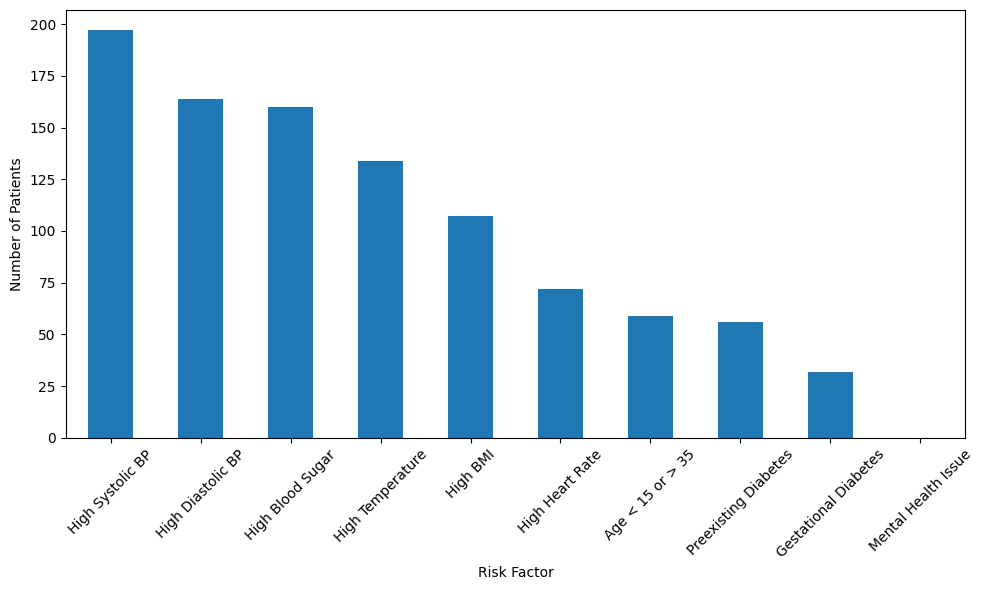

In [28]:
# Creates new binary features indicating presence of risk factor
df_eda["Syst_BP_Risk"] = df_eda["Systolic BP"] >= 140
df_eda["Diast_BP_Risk"] = df_eda["Diastolic BP"] >= 90
df_eda["BS_Risk"] = df_eda["Blood Sugar"] >= 5.6
df_eda["Temp_Risk"] = df_eda["Body Temp"] >= 100.4
df_eda["BMI_Risk"] = df_eda["BMI"] >= 25
df_eda["HR_Risk"] = df_eda["Heart Rate"] >= 100
df_eda["Pre_Diabetes_Risk"] = df_eda["Preexisting Diabetes"] == True
df_eda["Gest_Diabetes_Risk"] = df_eda["Gestational Diabetes"] == True
df_eda["MH_Risk"] = df_eda["Mental Health"] == True
df_eda["Age_Risk"] = (df_eda["Age"] < 15) | (df_eda["Age"] > 35)

# Define the list of risk factor columns
risk_columns = [
    "Syst_BP_Risk", "Diast_BP_Risk", "BS_Risk", "Temp_Risk",
    "BMI_Risk", "HR_Risk", "Age_Risk", "Pre_Diabetes_Risk",
    "Gest_Diabetes_Risk", "MH_Risk"
]

# Filter out rows with missing values in any of the relevant columns
df_risk = df_eda.dropna(subset=[
    "Systolic BP", "Diastolic BP", "Blood Sugar", "Body Temp",
    "BMI", "Heart Rate", "Age",
    "Preexisting Diabetes", "Gestational Diabetes", "Mental Health"
]).copy()

# Convert boolean risk indicators to integers
df_risk[risk_columns] = df_risk[risk_columns].astype(int)

# Calculate total number of risk factors per patient
df_risk["Total Risk Factors"] = df_risk[risk_columns].sum(axis=1)

# Calculate average number of risk factors by complication history
risk_by_prev_comp = df_risk.groupby("Previous Complications")["Total Risk Factors"].mean().reset_index()

# Filter to patients with previous complications and count risk factor frequency
df_prev = df_risk[df_risk["Previous Complications"] == 1]
risk_counts = df_prev[risk_columns].sum().sort_values(ascending=False)

# Rename the index to more descriptive risk factor names
risk_counts.index = [
    "High Systolic BP",
    "High Diastolic BP",
    "High Blood Sugar",
    "High Temperature",
    "High BMI",
    "High Heart Rate",
    "Age < 15 or > 35",
    "Preexisting Diabetes",
    "Gestational Diabetes",
    "Mental Health Issue"
]

# Plot the number of patients with each risk factor (among those with previous complications)
plt.figure(figsize=(10, 6))
risk_counts.plot(kind="bar")
plt.ylabel("Number of Patients")
plt.xlabel("Risk Factor")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Reflection

The most common risk factors for those that have experienced previous pregnancy related complications were high blood pressure, high blood sugar, high temperature, and high BMI. The least common were diabetes (preexisting, gestational) and mental health issues. This could give some indications what their previous complications may have been, but only show occurence, not correlation or causation.

The display of data may not be ideal, as it is impossible to determine if there are no coexisting mental health issues, or if the number is too low to discern. It may be better to display high and low counts seperately, or use a logarithmic y-axis.

#### How is BMI related to blood sugar levels and the presence of preexisting or gestational diabetes?

This is a multivariate analysis focussing on BMI, blood sugar, gestational and prexisting diabetes. The result will be shown as heatmap. The first step is to download seaborn.

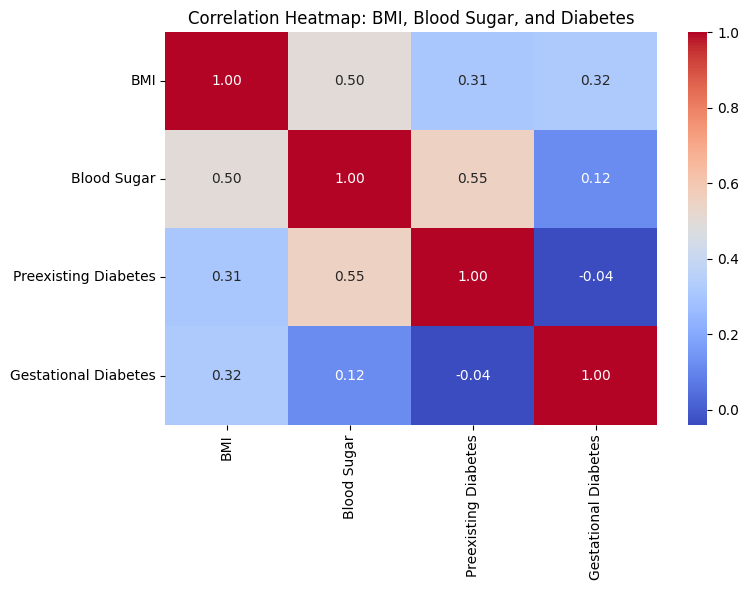

In [29]:
heatmap_data = df_eda[["BMI", "Blood Sugar", "Preexisting Diabetes", "Gestational Diabetes"]].dropna().copy() #get data for heatmap

# Convert boolean values to in
heatmap_data["Preexisting Diabetes"] = heatmap_data["Preexisting Diabetes"].astype(int)
heatmap_data["Gestational Diabetes"] = heatmap_data["Gestational Diabetes"].astype(int)

corr_matrix = heatmap_data.corr() # Calculate matric

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: BMI, Blood Sugar, and Diabetes")
plt.tight_layout()
plt.show()

#### Reflection

The heatmap shows a moderate positive association between BMI and high blood sugar (0.50), and a low moderate positive association with both preexisting and gestational diabetes (0.31 and 0.32). It also shows that preexisting diabetes has a high (0.55) positive association to blood sugar. Interestingly, this is not the case for gestational diabetes. Preexisting diabetes and gestational diabetes are booleans, converted to integers. Since they are binary, their correlation may seem weaker than when comparing two numerical values.

#### Examining the distrubtuion of blood sugar

The heatmap revealed a weaker relationship between blood sugar and gestational diabetes than between blood sugar and pre-existing diabetes. Here I will plot a histogram to compare the blood sugar distrubtion between the two groups to hopefully reveal what causes this difference.

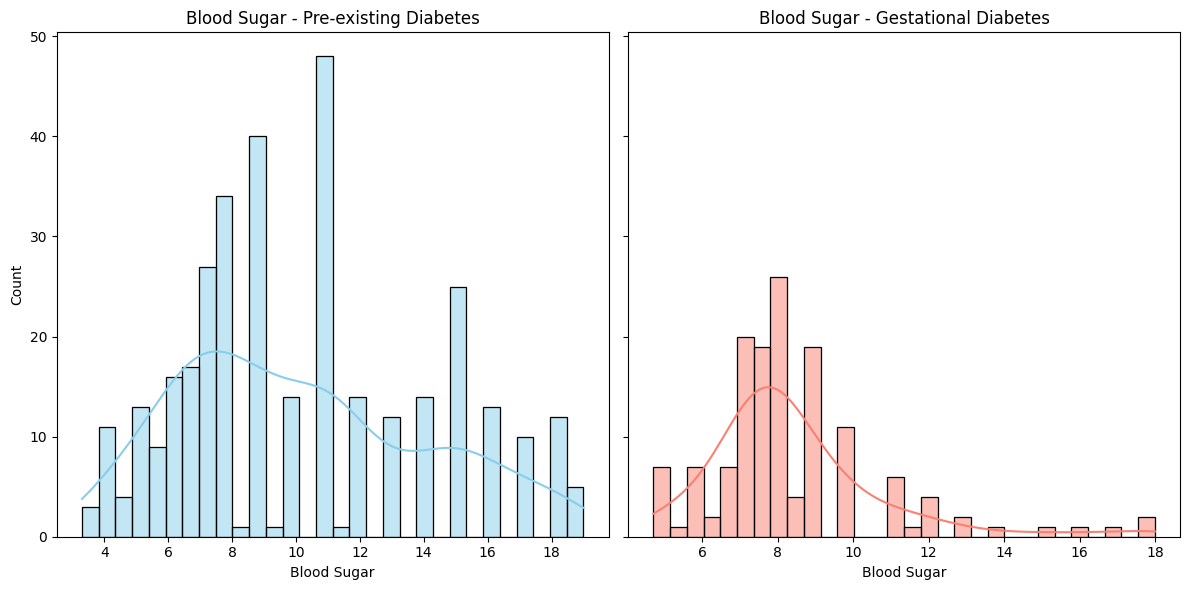

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)

# Histogram for pre-existing diabetes
sns.histplot(
    data=df_eda[df_eda['Preexisting Diabetes'] == True],
    x='Blood Sugar',
    bins=30,
    kde=True,
    ax=axes[0],
    color='skyblue'
)
axes[0].set_title('Blood Sugar - Pre-existing Diabetes')
axes[0].set_xlabel('Blood Sugar')

# Histogram for gestational diabetes
sns.histplot(
    data=df_eda[df_eda['Gestational Diabetes'] == True],
    x='Blood Sugar',
    bins=30,
    kde=True,
    ax=axes[1],
    color='salmon'
)
axes[1].set_title('Blood Sugar - Gestational Diabetes')
axes[1].set_xlabel('Blood Sugar')

plt.tight_layout()
plt.show()


#### Reflection

The histogram shows that for both groups, most blood sugar values would be considered high, i.e., 5.6 mmol/L or higher. However, the patients with pre-existing diabetes had a wider range and more values in the extremely high range. This is probably what causes the difference in the heatmap above; both groups are associated with high blood sugar values, but the distribution differs, and this likely makes the correlation matrix interpret it differently.

In other words, both pre-existing diabetes and gestational diabetes should be considered relevant when training the model on risk detection.

### Correlations

In this section I will examine correlation between different features. To get an idea of which statistical methods to use I will first perform Shapiro-Wilk on the numerical features to determine if they are normally distributed.

In [31]:
# list containing numerical features as variables
variables = {
    "Age": df_eda["Age"],
    "Blood Sugar": df_eda["Blood Sugar"],
    "Systolic BP": df_eda["Systolic BP"],
    "Diastolic BP": df_eda["Diastolic BP"],
    "BMI": df_eda["BMI"],
    "Heart Rate": df_eda["Heart Rate"],
    "Body Temp": df_eda["Body Temp"],
    "Previous Complications": df_eda["Previous Complications"],
    "Preexisting Diabetes": df_eda["Preexisting Diabetes"],
    "Gestational Diabetes": df_eda["Gestational Diabetes"],
    "Mental Health": df_eda["Mental Health"]
}

# Loop through the results to produce result for each variable
results = []
for var_name, var_data in variables.items():
  statistic, p_value = shapiro(var_data.dropna()) #perform shapiro test on all instances that are not null

  normality = 'Normally distributed' if p_value > 0.05 else 'Not normally distributed'
  results.append({'Variable': var_name, 'Statistic': statistic, 'P-value': p_value, 'Normality': normality})

# Create DataFrame
results_df = pd.DataFrame(results)


# Show table
results_df


,Variable,Statistic,P-value,Normality
0,Age,0.900476,3.036303e-27,Not normally distributed
1,Blood Sugar,0.842267,6.504069e-33,Not normally distributed
2,Systolic BP,0.960669,1.871674e-17,Not normally distributed
3,Diastolic BP,0.946435,1.903688e-20,Not normally distributed
4,BMI,0.967782,1.454256e-15,Not normally distributed
5,Heart Rate,0.958362,5.203385e-18,Not normally distributed
6,Body Temp,0.444487,2.077528e-51,Not normally distributed
7,Previous Complications,0.461028,6.952976e-51,Not normally distributed
8,Preexisting Diabetes,0.567721,2.330271e-47,Not normally distributed
9,Gestational Diabetes,0.375434,2.407979e-53,Not normally distributed


#### Correlation analyses

As none of the features are normally distributed, non-parametric methods will be used to assess correlations. The following combinations will be examined:

* **Two numerical variables:** Systolic blood pressure and diastolic blood pressure

* **Two categorical variables:** Mental health and risk level

#### Systolic blood pressure and diastolic blood pressure

In [32]:
# Drop rows where either column is NaN
df_corr = df_eda[["Systolic BP", "Diastolic BP"]].dropna()

# Calculate Spearman correlation
corr, p = spearmanr(df_corr["Systolic BP"], df_corr["Diastolic BP"])

print(f"Spearman correlation: {corr:.2f}")
print(f"P-value: {p:.4f}")

Spearman correlation: 0.79
P-value: 0.0000


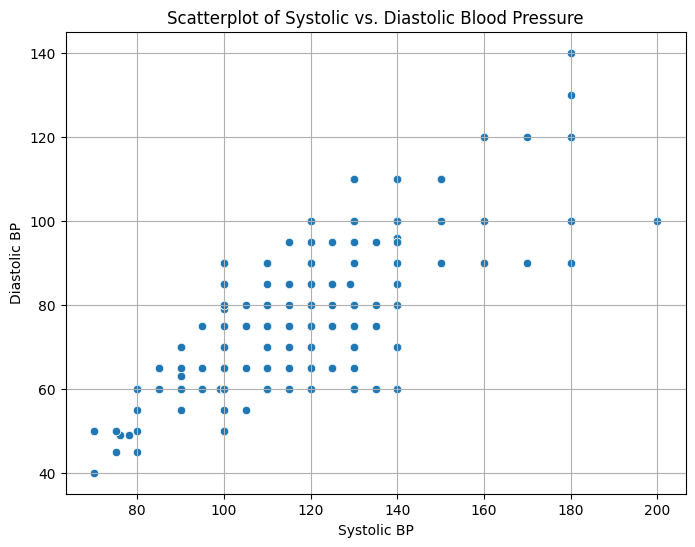

In [33]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_corr, x="Systolic BP", y="Diastolic BP")
plt.title("Scatterplot of Systolic vs. Diastolic Blood Pressure")
plt.grid(True)
plt.show()


#### Reflection

The analysis suggests a strong, though not perfect, relationship between systolic and diastolic blood pressure. This is expected, as both are components of the same cardiovascular process, and increases in one are often accompanied by increases in the other. However, the fact that the correlation is not perfect indicates that this pattern is not universal. A high systolic blood pressure does not automatically imply a high diastolic pressure, and vice versa. This distinction supports the decision to keep both variables separate in the analysis, as each may contribute unique information.

#### Mental health and risk level

In [34]:
# Create a contingency table
contingency_table = pd.crosstab(df_eda["Mental Health"], df_eda["Risk Level"])

# Run Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Contingency Table:")
print(contingency_table)
print("\nChi-square test statistic:", chi2)
print("P-value:", p)

Contingency Table:
Risk Level     Low  High
Mental Health           
False          647   140
True            64   334

Chi-square test statistic: 478.8991634634418
P-value: 3.7092303803920113e-106


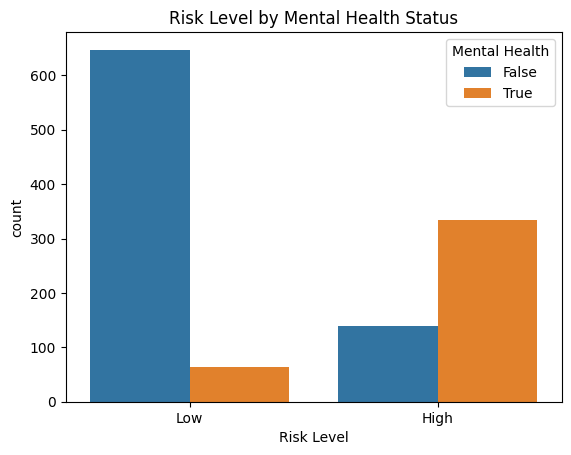

In [35]:
# Normalized bar plot
sns.countplot(data=df_eda, x="Risk Level", hue="Mental Health")
plt.title("Risk Level by Mental Health Status")
plt.show()

#### Reflection

The Chi-square test indicates a statistically significant association between mental health issues and high risk level. Patients with documented mental health conditions are considerably more likely to be classified as high risk compared to those without. While previous visualizations showed that mental health issues are relatively uncommon among patients with prior complications, this analysis highlights that, mental health is still strongly associated with elevated pregnancy risk. Therefore, it remains a relevant and valuable feature to retain in the predictive model.

## 3. Classification

The aim of this project is to build a predictive model that will classify pregnant patients as either high risk or low risk, based on their age, Systolic Blood Pressure, Diastolic Blood Pressure, BMI, diabetes, Previous Complications, and Mental Health.

## Reflection on choosen variables

**Target variable**

The purpose of the dataset is to serve as a basis for risk assessment of patients based on factors in their health profile that are associated with risks during pregnancy. Choosing Risk Level as the target variable is therefore the most logical and clinically relevant choice, as estimating whether a patient is likely to be at high risk based on a combination of factors is more complex and could meaningfully influence how their case is managed.

**Input features**

The selected features are all linked to a higher risk of causing complications

*   Post i listan
*   Post i listan

during pregnancy (see for example [the Mayo Clinic] (https://www.mayoclinic.org/healthy-lifestyle/pregnancy-week-by-week/in-depth/high-risk-pregnancy/art-20047012) or [Yale Medicine] (https://www.yalemedicine.org/conditions/high-risk-pregnancy)). While this applies to most features in the dataset, heart rate and body temperature were omitted, as their values were mostly within normal ranges and unlikely to add predictive value.

Additionally, preexisting and gestational diabetes will be merged into a single binary feature called Diabetes, while blood sugar will be excluded from the model. This decision is based on the fact that blood sugar was measured only once per patient, which may not accurately reflect their typical levels. While higher blood sugar was often observed among patients with diabetes, individuals with normal or even low readings might still experience elevated levels at other times, something this dataset does not capture. Moreover, patients with diabetes might be receiving treatment (e.g. insulin or other medications) that affects their risk profile independently of their blood sugar level at the time of measurement. Therefore, the presence of diabetes is considered a more consistent and reliable indicator of maternal risk, whereas the type of diabetes is not expected to add significant predictive value and will not be modeled separately.

 Age will be filtererd to only include those between the ages 18-45, as described during preprocessing.

In addition, features indicating suppressed values are included where imputation was applied. These act as flags for missing data and allow the model to account for uncertainty introduced by imputed values during training.

In [36]:
# Step 1: Create a copy for modeling
df_ml = df_clean.copy()

# Step 2: Create combined binary 'Diabetes' feature
df_ml["Diabetes"] = df_ml["Preexisting Diabetes"] | df_ml["Gestational Diabetes"]

# Step 3: Filter age to include only 18–45
df_ml = df_ml[(df_ml["Age"] >= 18) & (df_ml["Age"] <= 45)]

# Step 4: Select only the features you want to use in the model
selected_features = [
    "Age",
    "Systolic BP",
    "Diastolic BP",
    "BMI",
    "Diabetes",
    "Previous Complications",
    "Mental Health",
    "BMI Suppressed",
    "Risk Level"  # Target variable
]

df_ml = df_ml[selected_features]

df_ml.head()

,Age,Systolic BP,Diastolic BP,BMI,Diabetes,Previous Complications,Mental Health,BMI Suppressed,Risk Level
0,22,90.0,60.0,18.0,True,True,True,False,High
1,22,110.0,70.0,20.4,False,False,False,False,Low
2,27,110.0,70.0,23.0,False,True,False,False,Low
3,20,100.0,70.0,21.2,False,False,False,False,Low
4,20,90.0,60.0,19.7,False,False,False,False,Low


## Handling missing values

Missing values in the selected features will be handled as follows:

**Target variable**

All rows with missing values will be removed, as these can not bring any useful infromation to the model.

**Input features**

* For features with fewer than 10 missing values, the affected rows will be dropped.

* For features with 10 or more missing values, imputation will be performed using the median value of the feature.
  * In such cases, a corresponding binary flag will be created to indicate that the value was imputed (i.e., originally missing), allowing the model to account for any potential uncertainty introduced by the imputation.

In [37]:
# Removing nulls from target variable

df_ml = df_ml.dropna(subset=["Risk Level"])

In [38]:
df_ml.isnull().sum()[df_ml.isnull().sum() > 0] #shows all features with missing values

,0
Systolic BP,3
Diastolic BP,2
BMI,12
Diabetes,1
Previous Complications,1




All input features except for BMI have less than 10 missing values, meaning that these rows can be dropped as well. Mental health and Age do not contain any nulls.

In [39]:
# Removing nulls from input features

df_ml = df_ml.dropna(subset=["Systolic BP", "Diastolic BP", "Diabetes", "Previous Complications"])

df_ml.isnull().sum()[df_ml.isnull().sum() > 0] #shows all features with missing values


,0
BMI,12


In [40]:
df_ml.shape[0] #find out how many rows remain

1018

So far 1018 rows (about 84%) out of the 1206 we started with remains.

#### Impute missing values

BMI contains 12 nulls, which will be imputed using the median. The median is chosen because it is less sensitive to extreme values compared to the mean, which is important given that both the minimum BMI (15) and maximum BMI (37) are at the edges of the plausible range. Imputing a typical, non-extreme value is reasonable, as inserting an extreme value could distort the model’s understanding of the case. Using the median allows me to preserve the distribution's center without over- or underestimating risk.

In [41]:
# Find the median of BMI
median_bmi = df_ml["BMI"].median()

# Impute missing values and assign explicitly
df_ml["BMI"] = df_ml["BMI"].fillna(median_bmi)

# Confirm that there are no missing values left
print("Number of missing values:", df_ml["BMI"].isna().sum())


Number of missing values: 0


<ipython-input-41-4118286177>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml["BMI"] = df_ml["BMI"].fillna(median_bmi)


In [42]:
df_ml.head()

,Age,Systolic BP,Diastolic BP,BMI,Diabetes,Previous Complications,Mental Health,BMI Suppressed,Risk Level
0,22,90.0,60.0,18.0,True,True,True,False,High
1,22,110.0,70.0,20.4,False,False,False,False,Low
2,27,110.0,70.0,23.0,False,True,False,False,Low
3,20,100.0,70.0,21.2,False,False,False,False,Low
4,20,90.0,60.0,19.7,False,False,False,False,Low


## Perparing the Data for ML classification

I am starting be defining the input features as X.

In [43]:
# Create a subset of DF called X, containing the input features, including BMI Suppressed as this column contains imputed values
X = df_ml[[
    "Previous Complications", "Mental Health", "Age",
    "Systolic BP", "Diastolic BP", "BMI", "Diabetes", "BMI Suppressed"
]].copy()


### Preparing Categorical features for Classification Tasks


In this dataset, all input features are already in a numerical format — either float (diastolic BP, systolic BP, BMI), integer (Age), or boolean (Mental Health, Previous Complications, Diabetes, BMI Suppressed). The only categorical variable present is the target variable, which is not encoded here, as the encoding step is meant for the input features only.

Therefore, no ordinal or one-hot encoding was necessary for this dataset. Instead, the selected categorical input features will be converted into numerical values by using astype(int).

In [44]:
#Convert boolean features into int
X["Previous Complications"] = X["Previous Complications"].astype(int)
X["Mental Health"] = X["Mental Health"].astype(int)
X["BMI Suppressed"] = X["BMI Suppressed"].astype(int)
X["Diabetes"] = X["Diabetes"].astype(int)

In [45]:
# Ensuring all datatypes are numerical
X.dtypes

,0
Previous Complications,int64
Mental Health,int64
Age,int64
Systolic BP,float64
Diastolic BP,float64
BMI,float64
Diabetes,int64
BMI Suppressed,int64


#### Converting the Feature Set to a NumPy Array

To prepare the input features for machine learning, the DataFrame `X`, which now contains only numerical values, is converted into a Numpy array.

In [46]:
X = X.to_numpy() # Transforming pandas DataFrame into numpy array

#### Exploring the Target Class Distribution

The bar chart below shows the distribution of the binary target variable. This visualization helps assess whether the dataset suffers from class imbalance, which can affect the performance and fairness of classification models.

A bar chart was chosen because it is the most intuitive and appropriate method for displaying the distribution across risk levels when the target variable is categorical.

<Axes: xlabel='Risk Level'>

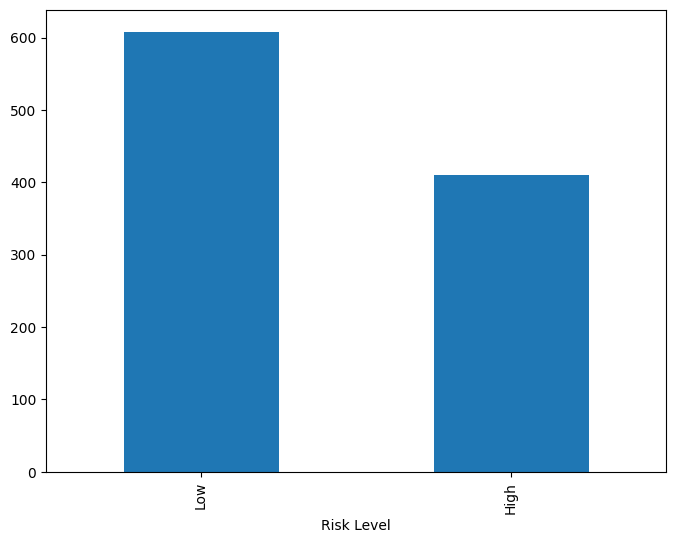

In [47]:
df_ml["Risk Level"].value_counts().plot(kind="bar", figsize=(8, 6))

In [48]:
# Calculate the percentage of patients assigned to each risk level category
proportion = df_ml["Risk Level"].value_counts(normalize=True) * 100

# Round to one decimal place and display with the high-risk category first
proportion = proportion.round(1).sort_values(ascending=True)

proportion

,proportion
Risk Level,
High,40.3
Low,59.7


This shows that roughly 40% of patients are considered high risk, while roughly 60% of patients were low risk.

While there is no universally agreed-upon threshold for when class imbalance becomes a problem, it is commonly accepted that if the minority class accounts for 10% or less of the data, special handling is required. Even under more cautious definitions, such as considering 30% moderately imbalanced, this dataset would still be considered balanced. Therefore, no additional measures are necessary to address class imbalance in this case.

#### Defining the Target Variable (y)

Since the input features have already been assigned to `X`, the next step is to define the target variable, `y`. This will be used to train the model to predict the risk level.

In [49]:
y = df_ml["Risk Level"].map({"Low": 0, "High": 1}) # Binarize the target variable and define it as y
y = y.to_numpy() # Turn into numpy array

#### Stratified Train-Test Split

The dataset is split into a training set (80%) and a test set (20%) using stratified sampling. Stratification ensures that the proportion of classes in the target variable is preserved across both sets. Stratification helps prevent accidental class imbalance during the split, which is especially important in smaller datasets.

While the dataset is relatively balanced (~60/40), it contains just over 1,100 observations after preprocessing. In such medium-sized datasets, stratification adds robustness by ensuring consistent class representation across training and testing, even when imbalance is not severe.

In [50]:
# Split the set into train and test data
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


#### Standardizing the data

Some of the classifiers used in the next step (namely K-Nearest Neighbors, Support Vector Machines, and Logistic Regression) either require or perform better with standardized data. Therefore, standardization will be applied to the input features before training the models.

In [51]:
scaler = StandardScaler()

X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

### 4. Evaluating the model

A total of five classifiers will be used: Decision Tree (DT), Random Forest (RF), K-Nearest Neighbors (KNN), Support Vector Machine (SVM), and Logistic Regression. All of these algorithms are commonly applied to medical datasets and have been widely used in disease prediction.

In [52]:
# Define two variants of classifiers with different hyperparameters
classifiers = {
    "Decision Tree (depth=5)": DecisionTreeClassifier(
        max_depth=5, class_weight="balanced", min_samples_leaf=5, random_state=42), #trying balanced to increase recall, even though set is moderately balanced
    "Decision Tree (depth=10)": DecisionTreeClassifier(
        max_depth=10, class_weight="balanced", min_samples_leaf=5, random_state=42),
    "Random Forest (500 trees": RandomForestClassifier(
        n_estimators=500, max_depth=5, class_weight="balanced", min_samples_leaf=5, random_state=42),
    "Random Forest (200 trees)": RandomForestClassifier(
        n_estimators=200, max_depth=5, class_weight="balanced", min_samples_leaf=10, random_state=42),
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=7, weights="uniform"),
    "KNN (k=9)": KNeighborsClassifier(n_neighbors=9, weights="distance"),
    "SVM (rbf)": SVC(kernel='rbf', C=0.3, gamma=0.05, probability=True, random_state=42),
    "SVM (linear)": SVC(kernel='linear', C=0.5, class_weight='balanced', probability=True, random_state=42),
    "LogReg (L2)": LogisticRegression(penalty='l2', C=0.5, class_weight='balanced', solver='liblinear', random_state=42),
    "LogReg (L1)": LogisticRegression(penalty='l1', C=1.0, class_weight='balanced', solver='liblinear', random_state=42)
}


#### Training

Each classifier in the dictionary is trained and validated on the standardized training data using 5 fold cross validation. For each model, training time, prediction time, and key performance metrics (accuracy, precision, recall, and F1-score) are recorded. This allows for a comparative analysis of their effectiveness in solving the prediction task.


In [53]:
# Define which metrics to track during cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

cv_results = []

# Loop through each classifier
for name, clf in classifiers.items():
    # Start timer for training + cross-validated prediction
    t_start = time.time()

    # Perform 5-fold cross-validation
    scores = cross_validate(
        clf,
        X_train_full,
        y_train_full,
        cv=5,
        scoring=scoring,
        return_train_score=False
    )

    t_end = time.time()

    # Estimate total time and split roughly 50/50 between training and prediction
    total_time = t_end - t_start
    training_time = total_time / 2
    prediction_time = total_time / 2

    # Save mean scores across all folds
    result = {
        "classifier_name": name,
        "training_time": round(training_time, 4),
        "prediction_time": round(prediction_time, 4),
        "accuracy": scores['test_accuracy'].mean(),
        "precision": scores['test_precision'].mean(),
        "recall": scores['test_recall'].mean(),
        "f1": scores['test_f1'].mean()
    }

    cv_results.append(result)

# Convert results to DataFrame
results = pd.DataFrame(cv_results)
results

,classifier_name,training_time,prediction_time,accuracy,precision,recall,f1
0,Decision Tree (depth=5),0.0816,0.0816,0.969295,0.955578,0.969464,0.962155
1,Decision Tree (depth=10),0.1118,0.1118,0.968060,0.955443,0.966387,0.960582
2,Random Forest (500 trees,5.2884,5.2884,0.968068,0.939027,0.984709,0.961277
3,Random Forest (200 trees),2.7774,2.7774,0.968075,0.939141,0.984709,0.961318
4,KNN (k=7),0.0508,0.0508,0.950852,0.928681,0.951142,0.939683
5,KNN (k=9),0.0271,0.0271,0.954548,0.931891,0.957296,0.944265
6,SVM (rbf),0.0887,0.0887,0.947179,0.927958,0.942005,0.934846
7,SVM (linear),0.0623,0.0623,0.948413,0.930749,0.942051,0.936336
8,LogReg (L2),0.0268,0.0268,0.956995,0.943018,0.951096,0.946873
9,LogReg (L1),0.0250,0.0250,0.955768,0.942799,0.948065,0.945279


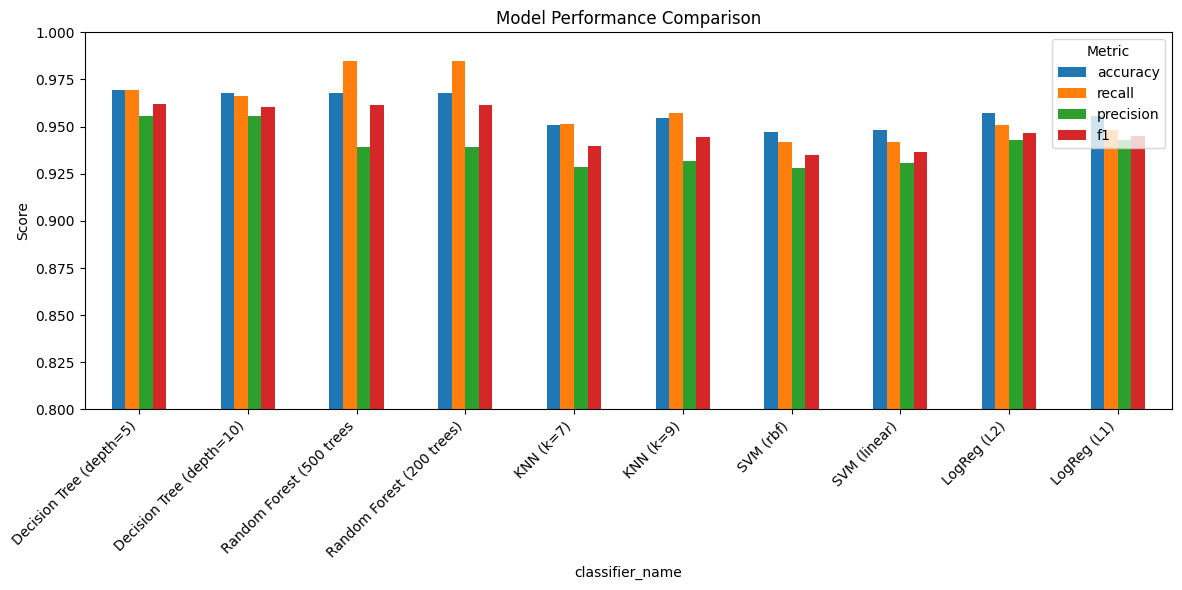

In [54]:
# Plot the result of perfomance metrics (excluding time)
metrics = ['accuracy', 'recall', 'precision', 'f1']
results.set_index('classifier_name')[metrics].plot(kind='bar', figsize=(12, 6))

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.8, 1.0)
plt.xticks(rotation=45, ha='right')  # Make labels readable
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

#### Rationale for Evaluation Metrics

The purpose of this prediction task is to identify pregnant patients who are at higher risk of experiencing complications. This can enable timely monitoring or intervention. The most serious consequence of incorrect prediction is the risk of producing a high number of false negatives (labeled as Low Risk when in fact High Risk). This means that patients who could benefit from additional interventions may not receive them in time.

False positives (labeled as High Risk when actually Low Risk) also carry real consequences, such as increased healthcare costs and misallocation of resources, where low-risk patients receive more care than necessary. Additionally, being incorrectly labeled as high-risk can cause unnecessary stress and psychological harm to the patient.

Furthermore, it is important to recognize that this dataset, while it includes several known risk factors, is not comprehensive. Certain clinically significant variables (such as previous cesarean section, placental position, or multiparity) are not included. As a result, a patient may be (correctly) labeled as Low Risk by the model but still be considered high risk from a clinical standpoint. For this reason, the model should only be used to identify patients who may require a High Risk label, not to exclude them. This again underscores why recall is more important than precision in this context.

Therefore, Recall and F1 Score should be prioritized when evaluating model performance. The most important goal is to avoid false negatives and to achieve a balance between recall and precision. However, Precision must also be considered.

Time (both training and prediction) is of lesser importance in this context, as the model is intended for risk stratification rather than real-time clinical action. Most likely, being assigned a higher risk category will influence the frequency or content of future follow-up visits rather than requiring immediate intervention. As such, decisions based on the model may occur over the course of days or even weeks. However, if two models are otherwise equal in terms of predictive performance, faster training or prediction time could serve as a tie-breaker when choosing which model to deploy.

### Final Evaluation on Test data

Based on the results, both versions of the Decision Tree and Random Forest classifiers, along with Logistic Regression using L2 regularization, were considered the top five performing models on the training set.

Logistic Regression (L2) and KNN (k=7) performed very similarly across recall and F1-score, with Logistic Regression having slightly better precision and lower computation time. Given its interpretability and efficiency, Logistic Regression was selected over KNN, although both could be considered viable options depending on the context.

In [55]:
top_models = {
    "Decision Tree (depth=5)": DecisionTreeClassifier(
        max_depth=5, class_weight="balanced", min_samples_leaf=5, random_state=42), #trying balanced to increase recall, even though set is moderately balanced
    "Decision Tree (depth=10)": DecisionTreeClassifier(
        max_depth=10, class_weight="balanced", min_samples_leaf=5, random_state=42),
    "Random Forest (500 trees)": RandomForestClassifier(
        n_estimators=500, max_depth=5, class_weight="balanced", min_samples_leaf=5, random_state=42),
    "Random Forest (200 trees)": RandomForestClassifier(
        n_estimators=200, max_depth=5, class_weight="balanced", min_samples_leaf=10, random_state=42),
    "LogReg (L2)": LogisticRegression(penalty='l2', C=0.5, class_weight='balanced', solver='liblinear', random_state=42),
}


In [56]:
test_results = []

for name, model in top_models.items():
    # Timing: training
    start_train = time.time()
    model.fit(X_train_full, y_train_full)
    end_train = time.time()
    training_time = round(end_train - start_train, 4)

    # Timing: prediction
    start_pred = time.time()
    y_pred_test = model.predict(X_test)
    end_pred = time.time()
    prediction_time = round(end_pred - start_pred, 4)

    # Evaluation
    recall = recall_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    accuracy = accuracy_score(y_test, y_pred_test)

    result = {
    "Model": name,
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1": f1,
    "Training Time (s)": training_time,
    "Prediction Time (s)": prediction_time
    }



    test_results.append(result)

# Convert results to DataFrame
testing = pd.DataFrame(test_results)
testing

,Model,Accuracy,Recall,Precision,F1,Training Time (s),Prediction Time (s)
0,Decision Tree (depth=5),0.995098,0.987805,1.000000,0.993865,0.0060,0.0004
1,Decision Tree (depth=10),0.995098,0.987805,1.000000,0.993865,0.0029,0.0003
2,Random Forest (500 trees),0.995098,1.000000,0.987952,0.993939,0.8042,0.0402
3,Random Forest (200 trees),0.995098,1.000000,0.987952,0.993939,0.3168,0.0152
4,LogReg (L2),0.990196,0.987805,0.987805,0.987805,0.0028,0.0003


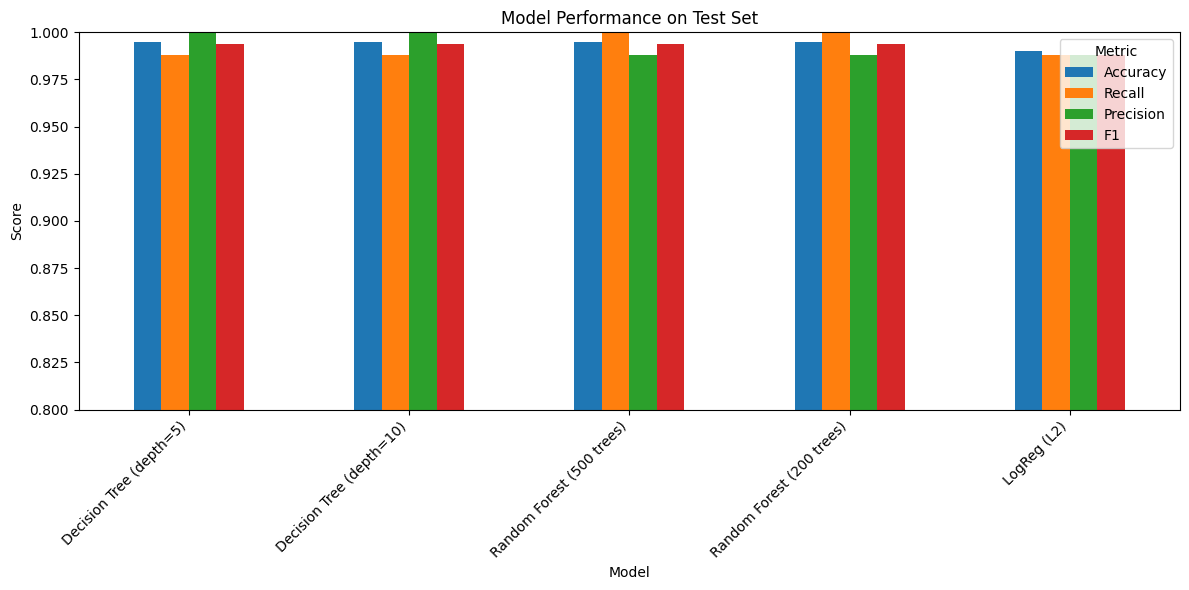

In [57]:
# Plot the performance metrics from the testing set
metrics = ['Accuracy', 'Recall', 'Precision', 'F1']  # Match column names exactly

testing.set_index('Model')[metrics].plot(kind='bar', figsize=(12, 6))

plt.title("Model Performance on Test Set")
plt.ylabel("Score")
plt.ylim(0.8, 1.0)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


Random Forst (200) Trees seem to be the best model when validating on the test set. It performs perfectly on recall, and next to perfect on other performance metrics. Additionally, it is faster to train and has a faster prediction time than Random Forest (500), that otherwise has identical performance metrics.

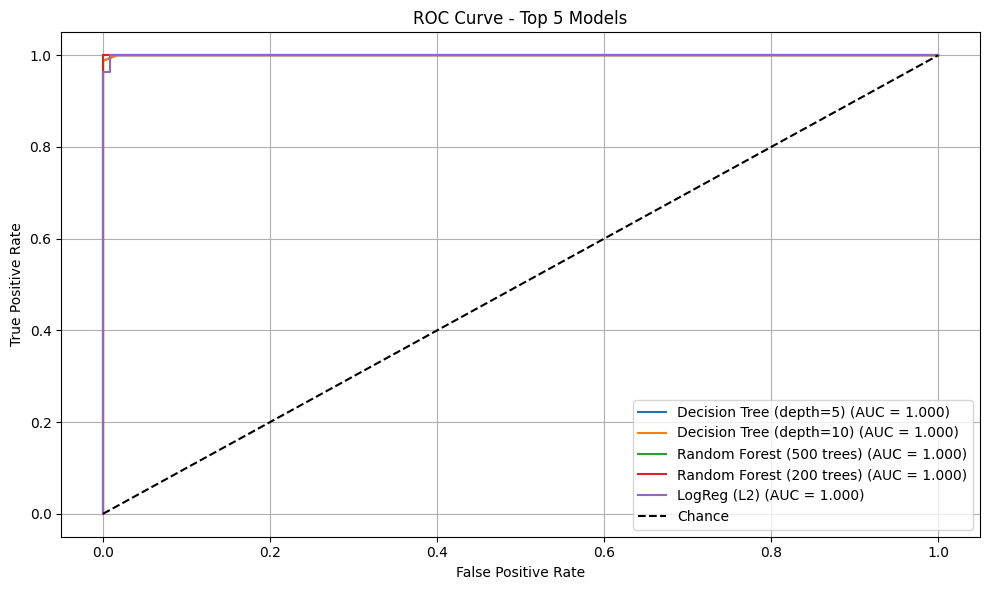

In [58]:
# Plot ROC curve

plt.figure(figsize=(10, 6))

for name, model in top_models.items():
    # Fit the model
    model.fit(X_train_full, y_train_full)

    # Get predicted probabilities
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    else:
        y_scores = model.decision_function(X_test)    # For SVMs, if used

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

# Chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.title("ROC Curve - Top 5 Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

The ROC curve are basically overlapping, suggesting that the models' perfomance is identical or highly similar. I will zoom in on the curves to get a better understanding of that is going on.

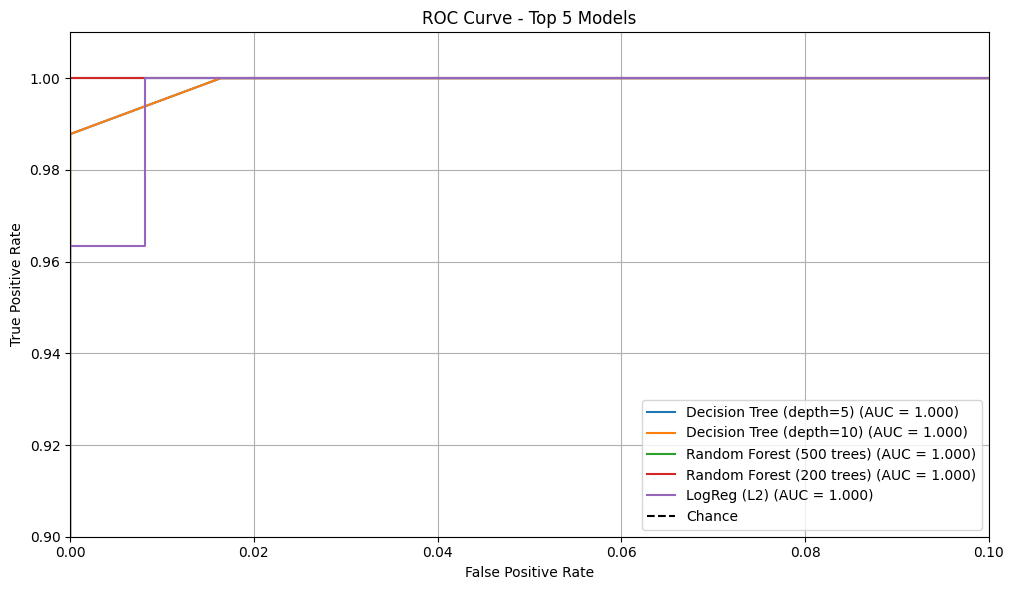

In [59]:
# Plot ROC curve

plt.figure(figsize=(10, 6))

for name, model in top_models.items():
    # Fit the model
    model.fit(X_train_full, y_train_full)

    # Get predicted probabilities
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

# Chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.title("ROC Curve - Top 5 Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.xlim(0, 0.1)
plt.ylim(0.9, 1.01)
plt.show()


In [60]:
for name, model in top_models.items():
    model.fit(X_train_full, y_train_full)
    proba = model.predict_proba(X_test)[:, 1]
    print(f"{name}: unique probabilities = {len(set(proba))}")


Decision Tree (depth=5): unique probabilities = 6
Decision Tree (depth=10): unique probabilities = 5
Random Forest (500 trees): unique probabilities = 193
Random Forest (200 trees): unique probabilities = 194
LogReg (L2): unique probabilities = 202


The ROC curves for the top 5 models are nearly identical and overlap almost perfectly, all achieving an AUC of 1.000. This suggests that the models are making highly similar predictions and are all very effective at distinguishing between the two classes in this dataset. Zooming in confirms that only slight differences exist in the low false positive range, indicating that the dataset may be easily separable. These findings are consistent with the high F1 and recall scores observed earlier.

There are several factors that could explain this. One possibility is that the data itself is too similar or predictable, although that seems unlikely, given that the EDA showed a wide spread of values and only clearly implausible or extreme outliers were removed. Another explanation is that the prediction task is simply too straightforward.

A more compelling possibility relates to the origin of the target feature. The metadata does not specify where the risk label comes from. So far, I have assumed it is a post-coordinated label applied to patients who experienced complications during pregnancy. But it could just as well be a clinician-assigned risk label recorded in the EHR, possibly generated through rule-based clinical guidelines or early warning systems. If that is the case, the label would already reflect patterns that align closely with thresholds in the input features. This would explain why tree-based models in particular perform so well - they may just be reproducing the same kind of splits that were used to generate the label in the first place.

## 4. Result

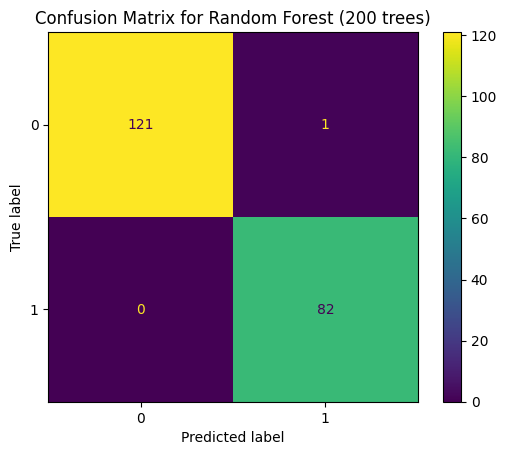

In [61]:
# Showing confusion matrix for selected modell

best_model = RandomForestClassifier(
    n_estimators=200, max_depth=5, class_weight="balanced", min_samples_leaf=10, random_state=42)

best_model.fit(X_train_full, y_train_full)

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Confusion Matrix for Random Forest (200 trees)")
plt.show()

The Random Forest (200 trees) shows strong results. Recall is 100%, meaning that it catches all positive instances. Precision is almost 99%, meaning that 1 out of 100 may be incorrectly labeled as High Risk.

The F1 score and accuracy are both around 99,5%, which woukd be considered a strong result for most models ( for example [Encord](https://encord.com/blog/f1-score-in-machine-learning/) considers values over 0.9 to indicate a strong performance, although this is not specific for medical prediction models). Training time and prediction time are both fast enough that they do not warrant chosing a different model.

The confusion matrix helps visualize these statistics. Out of 233 test samples:

* 121 true negatives and 82 true positives were correctly classified.

* 1 false positives and 0 false negatives occurred.

This means that 203 out of 204 cases were labeled correctly.

#### Consideration before implementaion

**Origin of the target variable**

The most important consideration before moving forward is understanding what the model is actually learning, which depends on how the risk label was assigned. If the label is derived from clinical guidelines, the model’s apparent accuracy may be misleading. In that case, it is not predicting patient outcomes, but rather mimicking predefined decision rules. This would mean that the model is simply a more computationally expensive way to replicate existing clinical practice.

In such scenarios, a faster and more transparent alternative would be to implement a non-AI, rule-based decision support system. If an AI tool is still desired, a better approach would be to train a model on a target variable based on actual patient outcomes, rather than clinician-assigned risk assessments.


**Further testing**

If, on the other hand, the target variable is indeed based on real clinical outcomes, the model shows very promising performance. In that case, further testing on larger and more diverse datasets is recommended to evaluate whether the model generalizes beyond this initial sample. Such testing should include more variation and noise to ensure the model outperforms existing clinical decision-making practices in a real-world setting.

#### Feature importance

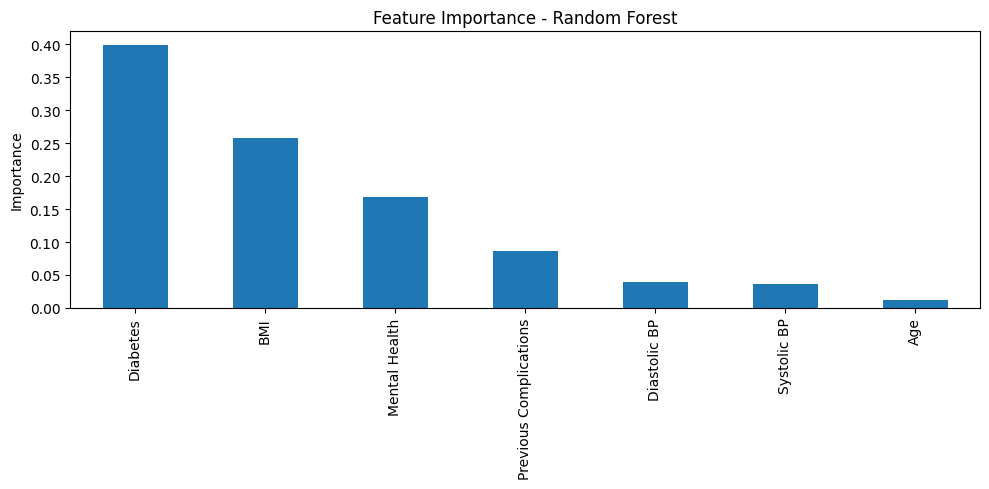

In [62]:
# All features used in the model
all_feature_names = [
    "Previous Complications", "Mental Health", "Age",
    "Systolic BP", "Diastolic BP", "BMI", "Diabetes", "BMI Suppressed"
]

# Feature importances
importances = best_model.feature_importances_

# Create a Series with all features
feat_imp_full = pd.Series(importances, index=all_feature_names)

# Drop the non-clinical one
feat_imp = feat_imp_full.drop("BMI Suppressed").sort_values(ascending=False)

# Plot
feat_imp.plot(kind='bar', figsize=(10, 5), title='Feature Importance - Random Forest')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


#### Reflection

Diabetes was the most important feature when determining risk category, followed by BMI. Since there is a degree of correlation between BMI and diabetes, this is not a surprising finding. However, it may be somewhat unexpected that the presence of mental health issues ranks third. This factor was a very uncommon risk marker among those with previous complications, yet it showed a high correlation with high risk during the analysis. This highlights the importance of including mental health in risk screening, in addition to biometric measures.

Blood pressure was among the least important factors, which is somewhat clinically unexpected as blood pressure (both systolic and diastolic) is one of the primary vital signs used to assess pregnancy-related risk in real-world clinical settings. This could depend on how the risk labels were generated, or on the distribution of blood pressure values in the dataset.

The least important feature was age, which aligns with earlier findings from the EDA, where age was shown to vary more at the individual level, and did not emerge as a strong global predictor.

### Chat function to test new patient data

In [63]:
# Define input prompts for each feature
input_data = {}

input_data["Previous Complications"] = int(input("Previous Complications (0 = No, 1 = Yes): "))
input_data["Mental Health"] = int(input("Mental Health Issues (0 = No, 1 = Yes): "))
input_data["Age"] = int(input("Age (years): "))
input_data["Systolic BP"] = float(input("Systolic Blood Pressure (mmHg): "))
input_data["Diastolic BP"] = float(input("Diastolic Blood Pressure (mmHg): "))
input_data["BMI"] = float(input("BMI: "))
input_data["Diabetes"] = int(input("Diabetes (0 = No, 1 = Yes): "))

# Convert to DataFrame
user_input_df = pd.DataFrame([input_data])

# Add the missing feature used during training
user_input_df["BMI Suppressed"] = 0  # or 1 depending on your case


# Predict using the best model
prediction = best_model.predict(user_input_df.values)[0]
probability = best_model.predict_proba(user_input_df.values)[0][1]

# Show results
if input_data["Age"] < 18:
  print("This model is not suitable to make risk assessments for patients younger than 18. Please refer to local clinical guidelines.")
elif input_data["Age"] > 45:
  print("This model is not suitable to make risk assessments for patients older than 45. Please refer to local clinical guidelines.")
else:
  print("\n--- Prediction Result ---")
  print("Risk Level Prediction:", "High Risk" if prediction == 1 else "Low Risk")
  print("Probability of High Risk:", round(probability*100, 2), "%")


Previous Complications (0 = No, 1 = Yes): 1
Mental Health Issues (0 = No, 1 = Yes): 0
Age (years): 24
Systolic Blood Pressure (mmHg): 134
Diastolic Blood Pressure (mmHg): 92
BMI: 23
Diabetes (0 = No, 1 = Yes): 0

--- Prediction Result ---
Risk Level Prediction: High Risk
Probability of High Risk: 73.53 %
